# Using `load_ard` to load and cloud mask multiple satellite sensors <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products Used:**
[s2a_msil2a](https://explorer.digitalearth.africa/s2a_msil2a),
[s2b_msil2a](https://explorer.digitalearth.africa/s2b_msil2a),
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene),
[ls7_usgs_sr_scene](https://explorer.digitalearth.africa/ls7_usgs_sr_scene),
[ls5_usgs_sr_scene](https://explorer.digitalearth.africa/ls5_usgs_sr_scene),

### Description
This notebook demonstrates how to use the `load_ard` function to import a time series of cloud-free observations over Africa from multiple Landsat satellites (i.e. Landsat 5, 7 and 8) and Sentinel-2 satellites (i.e. Sentinel-2A and Sentinel-2B).
The function automatically applies cloud masking to the input data and returns all available data from multiple sensors as a single combined `xarray.Dataset`.

Optionally, the function can be used to return only observations that contain a minimum proportion of good quality non-cloudy or shadowed pixels.
This can be used to extract visually appealing time series of observations that are not affected by cloud.

The `load_ard` function currently supports the following products: 

* USGS Collection 1: `ls8_usgs_sr_scene`, `ls7_usgs_sr_scene`, `ls5_usgs_sr_scene`
* USGS Collection 2: `usgs_ls8c_level2_2` (provisional, can only load on admin Sandbox)
* Sentinel 2: `s2a_msil2a`, `s2b_msil2a`


This notebook demonstrates how to use `load_ard` to
1. Load and combine Landsat 5, 7 and 8 data into a single `xarray.Dataset`
2. Optionally apply a cloud mask to the resulting data
3. Filter resulting data to keep only cloud-free observations
4. Filter data before loading using a custom function
5. Load and combine Sentinel-2A and -2B data into a single `xarray.Dataset`
6. Lazily load data using Dask

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [42]:
%matplotlib inline

import sys 
import datacube
import matplotlib.pyplot as plt
import datacube.utils.rio
import sys

sys.path.append("../Scripts")
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_plotting import rgb


### Connect to the datacube


In [57]:
# Connect to datacube 
dc = datacube.Datacube(app='Sentinel_2_play')

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)


In [58]:
# Create a query object
query = {
    'x': (-1.9, -2),
    'y': (6.9,7),
    "time": ("2018-01", "2018-02"),
    "resolution": (-10, 10),
    "group_by": "solar_day",
}

In [59]:
# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='s2_l2a', query=query)

#load data
ds = dc.load(product="s2_l2a",
             output_crs = output_crs,
             dask_chunks={},
             **query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 12, x: 1108, y: 1109)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T10:33:57 ... 2018-02-26T10:33:13
  * y            (y) float64 7.739e+05 7.739e+05 ... 7.628e+05 7.628e+05
  * x            (x) float64 6.105e+05 6.105e+05 ... 6.215e+05 6.215e+05
    spatial_ref  int32 0
Data variables:
    B01          (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    B02          (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    B03          (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    B04          (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    B05          (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    B06          (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    B07          (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    B08   

In [60]:
# # Identify the most common projection system in the input query
# output_crs = mostcommon_crs(dc=dc,
#                             product='s2_l2a',
#                             query={'x': (-1.9, -2), 'y': (6.9,7)})

In [69]:
# dataset = dc.find_datasets(product ='s2_l2a', output_crs = output_crs, platform = 'sentinel-2a',**query)

In [70]:
# len(dataset)
# #dataset[0].__dict__

6

## Loading Sentinel-2 data
Data from the Sentinel-2A and Sentinel-2B satellites can also be loaded using `load_ard`. To do this, we need to specify the two Sentinel-2 products (`['s2a_msil2a', 's2b_msil2a']`). The query parameter can be reused to load Sentinel-2 data for the same specifcations used for the Landsat data:

In [71]:
# Load available data from both S2 datasets
s2 = load_ard(dc=dc,
              products=['s2_l2a'], 
              output_crs='epsg:6933',
              measurements = ['red','green','blue'],
              **query)

# Print output data
print(s2)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a


KeyError: 'scl'

Cloudy pixels are masked out by default from the resulting observations similarly to Landsat:

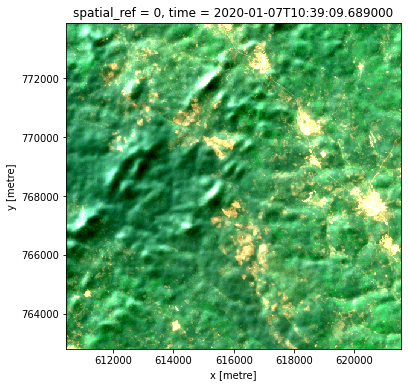

In [10]:
# Plot single observation
rgb(s2, index=1)

## Lazy loading with Dask
Rather than load data directly - which can take a long time and large amounts of memory - all datacube data can be lazy loaded using Dask. This can be a very useful approach for when you need to load large amounts of data without crashing your analysis, or if you want to subsequently scale your analysis by distributing tasks in parallel across multiple workers.

The load_ard function can be easily adapted to lazily load data rather than loading it into memory by providing a dask_chunks parameter using either the explicit or query syntax. The minimum required to lazily load data is `dask_chunks={}`, but chunking can also be performed spatially (e.g. `dask_chunks={'x': 3000, 'y': 3000}`) or by time (e.g. `dask_chunks={'time': 1}`) depending on the analysis being conducted.
See the [Dask documentation](https://docs.dask.org/en/latest/array-chunks.html) for more information about setting chunk sizes.

To learn more about lazy-loading with Dask, see the [Dask notebook](../Beginners_guide/06_parallel_processing_with_dask.ipynb).

In [14]:
# Load available data from both S2 datasets
s2 = load_ard(dc=dc,
              products=['s2a_msil2a', 
                        's2b_msil2a'], 
              output_crs=output_crs,
              resolution=(-10, 10),
              dask_chunks={'time': 1, 'x': 3000, 'y': 3000},
              **query)

# Print output data
print(s2)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2a_msil2a
    s2b_msil2a
Applying pixel quality/cloud mask
Returning 7 time steps as a dask array
<xarray.Dataset>
Dimensions:  (time: 7, x: 1108, y: 1109)
Coordinates:
  * y        (y) float64 7.739e+05 7.739e+05 7.739e+05 ... 7.628e+05 7.628e+05
  * x        (x) float64 6.105e+05 6.105e+05 6.105e+05 ... 6.215e+05 6.215e+05
  * time     (time) datetime64[ns] 2017-02-26T10:37:18.460000 ... 2017-04-27T10:29:59.096000
Data variables:
    red      (time, y, x) float32 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    green    (time, y, x) float32 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    blue     (time, y, x) float32 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
Attributes:
    crs:      epsg:32630


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Mar 2020

**Compatible datacube version:** 

In [15]:
print(datacube.__version__)

1.7+253.ga031f3f4.dirty


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)